In [23]:
# ---- image export setup ----
import sys, subprocess, importlib

def pip_i(spec: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", spec])

try:
    import plotly, pkg_resources
    from packaging.version import Version
    if Version(plotly.__version__) < Version("6.1.1"):
        pip_i("plotly>=6.1.1")
except Exception:
    pip_i("plotly>=6.1.1")

# Pin Kaleido to the compatible build
try:
    import kaleido
    from packaging.version import Version
    if Version(kaleido.__version__) != Version("0.2.1"):
        pip_i("kaleido==0.2.1")
except Exception:
    pip_i("kaleido==0.2.1")

import plotly.io as pio

# Only set scope if kaleido is actually loaded
if getattr(pio, "kaleido", None) and getattr(getattr(pio, "kaleido", None), "scope", None):
    pio.kaleido.scope.default_width  = 1600
    pio.kaleido.scope.default_height = 900
else:
    print("Kaleido scope not available yet")

# where to store survey images
from pathlib import Path
SURVEY = (Path().resolve().parent / "figures" / "survey")
SURVEY.mkdir(parents=True, exist_ok=True)
print("Export folder:", SURVEY)


Export folder: /Users/macbookair/Documents/resource_availability_tool/figures/survey


/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_8226/2644509435.py:28: DeprecationWarning:


Use of plotly.io.kaleido.scope.default_width is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.default_width instead.


/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_8226/2644509435.py:29: DeprecationWarning:


Use of plotly.io.kaleido.scope.default_height is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.default_height instead.




In [24]:
#Setup & paths 

from pathlib import Path
import sys, pandas as pd, plotly.express as px

SRC = Path().resolve().parent / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from availability import compute_daily_spans, extract_breaks, weekly_availability_matrix
from multitask   import overlap_summary  

DERIV = (Path().resolve().parent / "data" / "derived").resolve()

DATASETS = {
    "bpi2017":  {"stem": "bpi2017__tol_5min"},
    "sepsis":   {"stem": "sepsis__tol_5min"},
    "bpi2019":  {"stem": "bpi2019__tol_5min"},
}

def _read_frames(stem: str) -> dict:
    def _p(suffix): return DERIV / f"{stem}_{suffix}.parquet"
    out = {}
    for k in ["periods","daily_spans","breaks","weekly_availability","task_periods","overlap_kpi"]:
        fp = _p(k)
        out[k] = pd.read_parquet(fp) if fp.exists() else pd.DataFrame()
    return out

DS   = "sepsis"                 #  switch dataset here
STEM = DATASETS[DS]["stem"]
F    = _read_frames(STEM)

periods = F["periods"].copy()
daily   = F["daily_spans"].copy()
breaks  = F["breaks"].copy()
weekly  = F["weekly_availability"].copy()
tasks   = F["task_periods"].copy()
olap    = F["overlap_kpi"].copy()

print(DS, "|",
      "periods:", periods.shape, "|",
      "daily:", daily.shape, "|",
      "breaks:", breaks.shape, "|",
      "weekly:", weekly.shape, "|",
      "tasks:", tasks.shape, "|",
      "overlap_kpi:", olap.shape)


sepsis | periods: (8494, 6) | daily: (3118, 7) | breaks: (5376, 6) | weekly: (478, 3) | tasks: (0, 0) | overlap_kpi: (0, 0)


Resources: 26


,resource,days_active,avg_pct_busy,mean_arr_hour,mean_dep_hour,lunch_rate,overlap_share
0,B,478,8.4%,5.76,17.26,28.6%,0.0%
1,C,419,35.1%,10.74,17.02,27.2%,0.0%
2,A,416,16.0%,9.13,17.87,27.5%,0.0%
3,E,383,49.0%,11.10,13.89,33.6%,0.0%
4,?,216,73.8%,12.22,14.57,11.7%,0.0%
5,F,174,80.1%,11.89,13.27,10.5%,0.0%
6,O,155,82.4%,13.46,14.51,10.0%,0.0%
7,G,126,85.0%,14.39,16.30,0.0%,0.0%
8,I,106,85.5%,13.05,13.85,6.2%,0.0%
9,M,75,89.0%,13.40,14.05,66.7%,0.0%


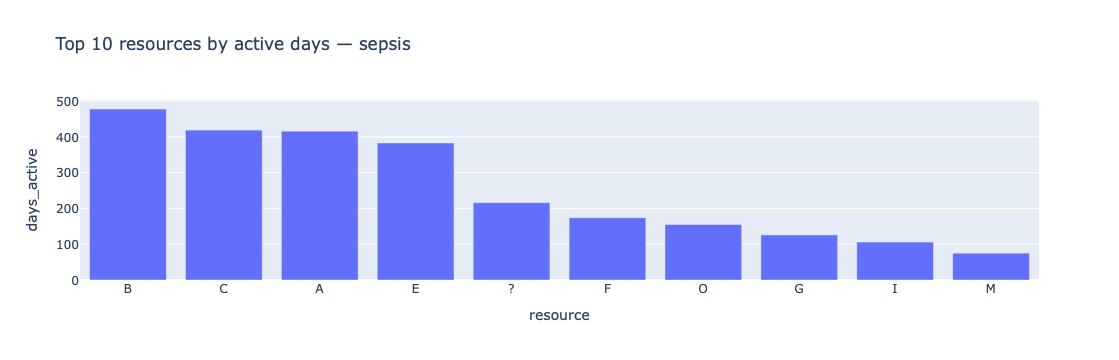

In [25]:
# Build per-resource summary table

import numpy as np

def _lunch_rate_for(res_id: str, window=(11.5,13.5), min_gap=30) -> float:
    if breaks.empty:
        return 0.0
    b = breaks[breaks["resource"] == res_id].copy()
    if b.empty:
        return 0.0
    b["start_hour_real"] = pd.to_datetime(b["gap_start"]).dt.hour + pd.to_datetime(b["gap_start"]).dt.minute/60
    ok = (b["start_hour_real"].between(window[0], window[1])) & (b["gap_min"] >= min_gap)
    days_total = b["day"].nunique()
    days_lunch = b.loc[ok, "day"].nunique()
    return (days_lunch / days_total) if days_total else 0.0

# overlap share per resource 
if not olap.empty:
    olap_idx = olap.set_index("resource")[["busy_min","overlap_min","overlap_share"]]
else:
    if tasks.empty:
        olap_idx = pd.DataFrame(columns=["busy_min","overlap_min","overlap_share"])
    else:
        o = overlap_summary(tasks)
        olap_idx = o.set_index("resource")[["busy_min","overlap_min","overlap_share"]]

rows = []
for res in sorted(daily["resource"].unique()):
    d = daily[daily["resource"] == res]
    rows.append(dict(
        resource=res,
        days_active=int(d["day"].nunique()),
        avg_pct_busy=float(d["pct_busy"].mean()),
        mean_arr_hour=float(pd.to_datetime(d["first_start"]).dt.hour.mean()),
        mean_dep_hour=float(pd.to_datetime(d["last_end"]).dt.hour.mean()),
        lunch_rate=_lunch_rate_for(res),
        overlap_share=float(olap_idx.loc[res, "overlap_share"]) if res in olap_idx.index else 0.0
    ))

summary = (pd.DataFrame(rows)
           .sort_values(["days_active","avg_pct_busy"], ascending=[False, False])
           .reset_index(drop=True))

pretty = summary.copy()
for c in ["avg_pct_busy","lunch_rate","overlap_share"]:
    pretty[c] = (pretty[c]*100).round(1).astype(str) + "%"
pretty["mean_arr_hour"] = pretty["mean_arr_hour"].round(2)
pretty["mean_dep_hour"] = pretty["mean_dep_hour"].round(2)

print(f"Resources: {len(summary)}")
display(pretty.head(12))

px.bar(summary.nlargest(10, "days_active"),
       x="resource", y="days_active",
       title=f"Top 10 resources by active days — {DS}").show()
summary.to_csv("artifacts/bpi2017_resource_summary.csv", index=False)


Profiling resource → B


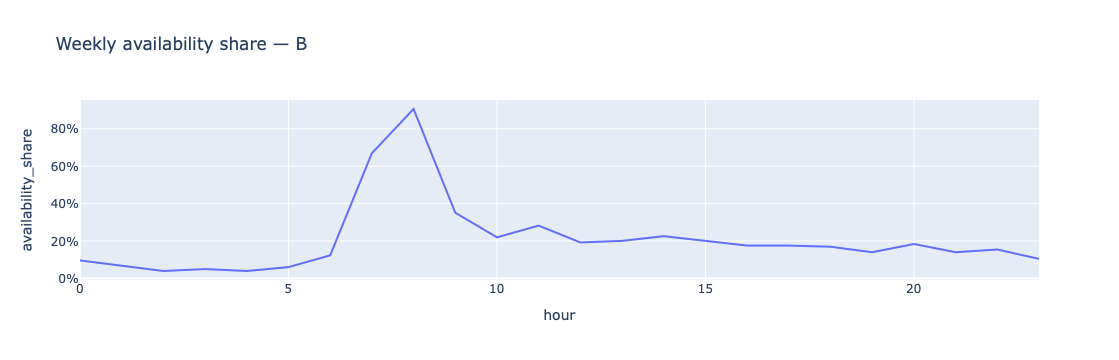

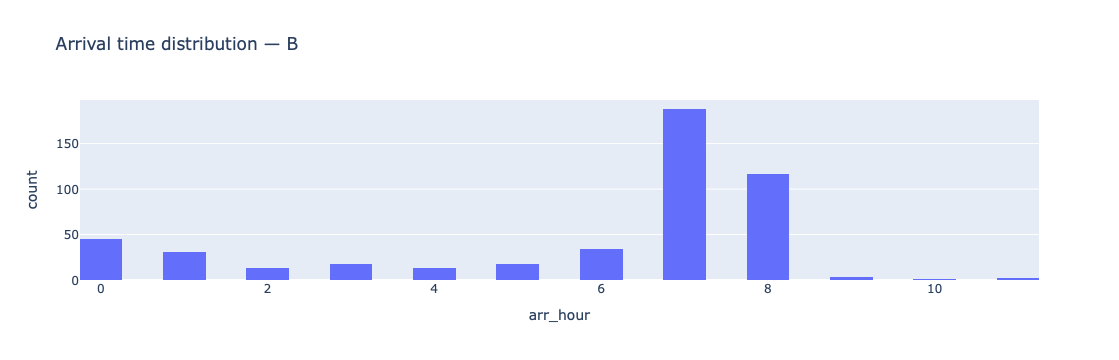

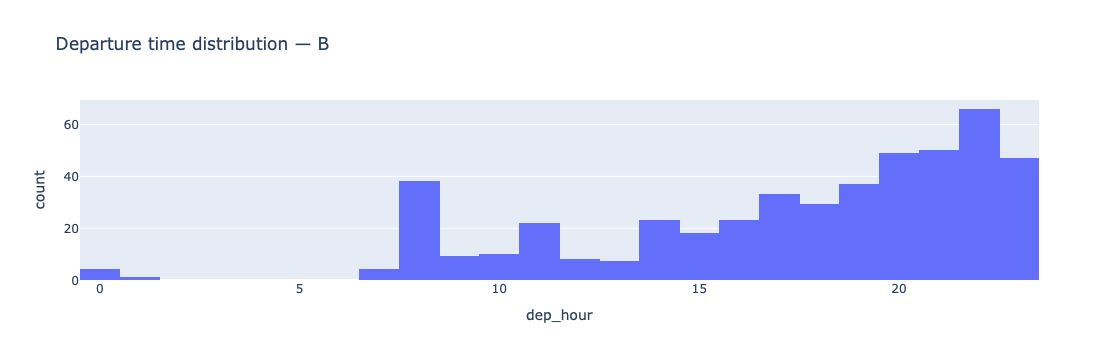

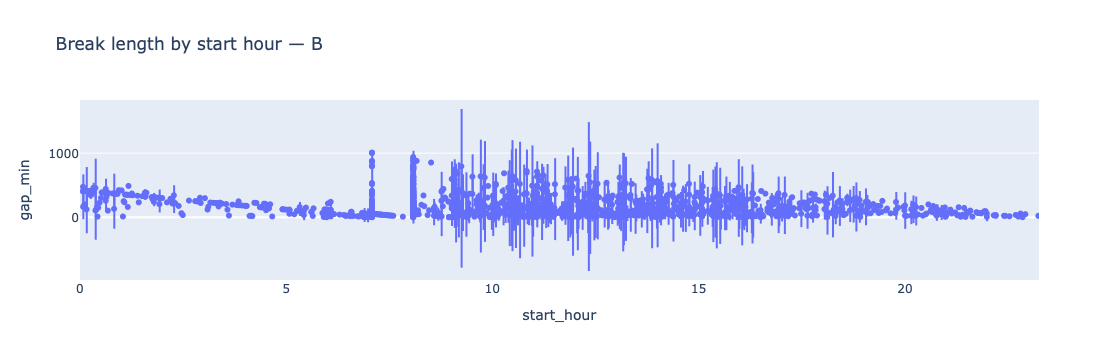

Busiest day → 2014-08-27 (n=17)


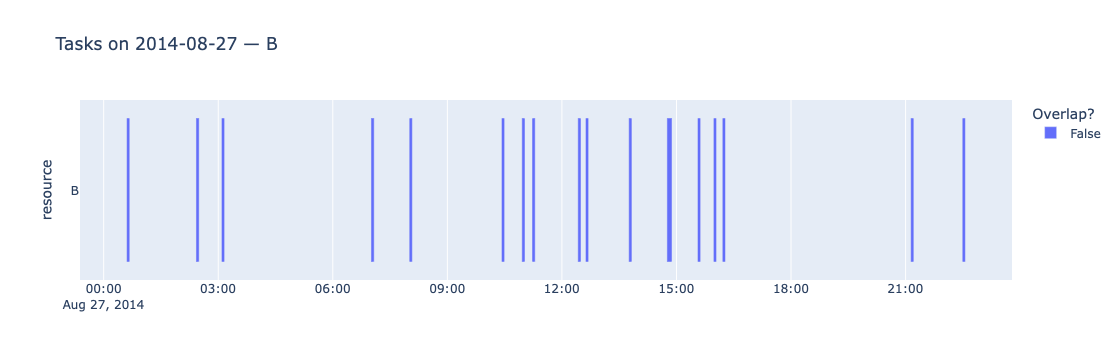

/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_8226/3241515016.py:43: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




In [26]:
#  Profile a selected resource end-to-end

RESOURCE = summary.iloc[0]["resource"] if len(summary) else None
print("Profiling resource →", RESOURCE)

if RESOURCE is None:
    print("No resources found.")
else:
    wk = weekly[weekly["resource"] == RESOURCE]
    fig = px.line(wk, x="hour", y="availability_share",
                  title=f"Weekly availability share — {RESOURCE}")
    fig.update_yaxes(tickformat=".0%"); fig.show()

    d = daily[daily["resource"] == RESOURCE].copy()
    d["arr_hour"] = pd.to_datetime(d["first_start"]).dt.hour
    d["dep_hour"] = pd.to_datetime(d["last_end"]).dt.hour
    px.histogram(d, x="arr_hour", nbins=24, title=f"Arrival time distribution — {RESOURCE}").show()
    px.histogram(d, x="dep_hour", nbins=24, title=f"Departure time distribution — {RESOURCE}").show()

    b = breaks[breaks["resource"] == RESOURCE].copy()
    if not b.empty:
        b["start_hour"] = pd.to_datetime(b["gap_start"]).dt.hour + pd.to_datetime(b["gap_start"]).dt.minute/60
        px.violin(b, x="start_hour", y="gap_min", box=True, points="all",
                  title=f"Break length by start hour — {RESOURCE}").show()
    else:
        print("No intra-day breaks detected for this resource.")

    # busiest day timeline
    p = periods[periods["resource"] == RESOURCE].copy()
    if not p.empty:
        p["start"] = pd.to_datetime(p["start"]); p["end"] = pd.to_datetime(p["end"])
        if "is_overlap" not in p.columns:
            p["is_overlap"] = False
        busiest_day = p["start"].dt.date.value_counts().idxmax()
        one = p[p["start"].dt.date == busiest_day].copy()
        print(f"Busiest day → {busiest_day} (n={len(one)})")
        px.timeline(one, x_start="start", x_end="end", y="resource",
                    color="is_overlap",
                    title=f"Tasks on {busiest_day} — {RESOURCE}",
                    labels={"is_overlap":"Overlap?"}
                   ).update_yaxes(autorange="reversed").show()
        out_fn = SURVEY / f"q1_resX_busiest_day.png"
        fig.write_image(out_fn, scale=2)


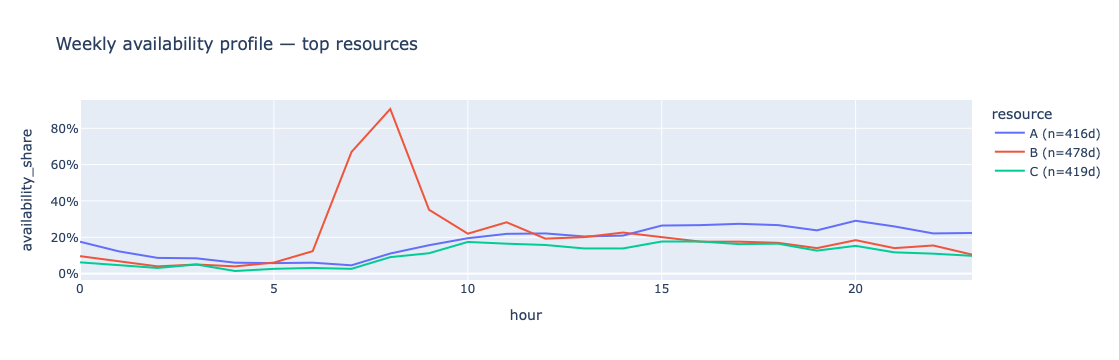

In [27]:
#Compare top 3 weekly availability

if len(summary) >= 3 and not weekly.empty:
    top3 = summary.nlargest(3, "days_active")["resource"].tolist()
    days = daily.groupby("resource")["day"].nunique()
    name_map = {r: f"{r} (n={int(days[r])}d)" for r in top3}
    plot_df = weekly[weekly["resource"].isin(top3)].copy()
    plot_df["resource"] = plot_df["resource"].map(name_map)
    fig = px.line(plot_df, x="hour", y="availability_share", color="resource",
                  title="Weekly availability profile — top resources")
    fig.update_yaxes(tickformat=".0%"); fig.show()
